# Churn / Customer Retention Modeling in R
From a strategic perspective, we would like to identify customers who are more likely to churn earlier in the process so
we can have a meaningful interaction with the subscriber to help them achieve their goals.

From a modeling perspective, we would like to gain insight from our data into behavior, variables and patterns that indicate higher probabilty of churn.Then, we'd like to predict churn and in turn, feed it back into the business to drive results. 

In [760]:
#Load in libraries
library(dplyr)
library(binr)
library(OneR)
library(ggplot2)
library(GGally)
library(car)
library(reshape)
library(devtools)
library(openxlsx)
library(zip)
library(RColorBrewer)
library(caret)
library(e1071)
library(pROC)
library(plotly)
library(crosstalk)
library(randomForest)
library(rpart)
library(adabag)
# R.Version()

Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


In [344]:
# load in the data. The data was pre-cleaned with a mixture of python and R after querying the source database.
model_data <- read.csv('df_combined_012619.csv')

In [558]:
#It looks like there are duplicates in here since there are 9,562 levels of what should be a unique columns
#with 9,925 observations. Going to remove them later with duplicated function. Here we can see that the the long data 
#has been converted to a tidy format (57,000 rows containing multiple months per customer > one row per client)
str(model_data)

'data.frame':	9925 obs. of  61 variables:
 $ X                              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ pid                            : Factor w/ 9562 levels "10Agu9063","10Ala9061",..: 2539 9236 1027 1309 4303 5176 2753 5283 5308 3337 ...
 $ birth.year                     : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1379 1151 3493 4423 7082 2433 2889 103 1699 ...
 $ first.payment                  : Factor w/ 288 levels "2018-01-17","2018-01-24",..: 231 112 NA 253 133 227 122 153 152 68 ...
 $ last.payment                   : Factor w/ 3015 levels "2018-01-17 00:00:00",..: 1803 759 243 2026 2136 1457 2587 1796 999 2420 ...
 $ transaction.count              : int  4 8 NA 3 8 4 8 6 7 11 ...
 $ total.spend                    : num  596 392 NA 447 792 ...
 $ processor                      : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ customer.status                : Factor w/ 2 levels "Existing","New": 2 1 2 1 1 2 2 1 2 1 ...
 $ clinic.id         

In [ ]:
#Create a new data frame to hold the data we want
model_data_discrete <- model_data %>% select (pid,avg_weight_change,avg_visits, stdev_weight_change,stdev_visits,
                                              consec_0_visits_v2,first_month_weightlost, first_month_weightgain, membership, processor,
                                              total.spend,birth.year,churn_v2)

In [ ]:
#remove duplicates
model_data_discrete <- model_data_discrete[!duplicated(model_data_discrete$pid),]

In [559]:
#confirm the dups are removed
print(paste("There are",length(unique(model_data_discrete$pid)),"customer IDs and the number of rows = ",dim(model_data_discrete)[1]))

[1] "There are 9550 customer IDs and the number of rows =  9550"


In [412]:
#read in new data with gender added
gender_data <- read.csv('datawithgenderbothpids.csv', stringsAsFactors = FALSE)
head(gender_data)

X.1,X,pid,birth.year,first.payment,last.payment,transaction.count,total.spend,processor,customer.status,...,first_month_0_visits,consec_0_visits,consec_0_visits_v2,first_month_visited,firstpay_index,churn_v2,visitsuntil_weightlost,visitsuntil_weightlost_factor,pid2,gender
1,1,24Oes9064,1962-04-26,2018-10-25,2018-12-25 18:13:00,4,596,Stripe,New,...,1,8,0,9,9,NoChurn,1,1,24OesM4471,F
2,2,9Coy9025,1954-06-14,2018-06-01,2018-12-01 18:39:00,8,392,Stripe,Existing,...,1,6,1,2,5,Churn,-1,Didnt Lose Weight,9CoyA5182,F
3,3,17Abo9059,1952-12-07,NA,2018-06-18 16:41:00,NA,NA,Stripe,New,...,1,5,1,4,4,Churn,1,1,17AboS9791,F
4,4,19Bar1443,1965-06-07,2018-11-28,2018-12-28 17:03:00,3,447,Stripe,Existing,...,1,9,0,10,10,NoChurn,2,2 to 3,19BarM4357,F
5,5,33Fai3547,1969-12-09,2018-06-29,2018-12-29 20:04:00,8,792,Stripe,Existing,...,1,5,1,6,5,Churn,1,1,33FaiK4793,F
6,6,40Gra9064,1993-10-31,2018-10-19,2018-12-19 19:28:00,4,247,Stripe,New,...,1,8,0,9,9,NoChurn,2,2 to 3,40GraK4623,F


In [415]:
#joining in gender data and corrected primary key
model_data_discrete <- left_join(model_data_discrete, gender_data[,c('pid','pid2','gender','visitsuntil_weightlost_factor')], by = 'pid')

Warning message:
"Column `pid` joining factor and character vector, coercing into character vector"

In [453]:
# str(model_data_discrete$gender)
# model_data_discrete$gender <- tolower(model_data_discrete$gender)
# model_data_discrete$gender <- ifelse(model_data_discrete$gender == 'm','Male','Female')
model_data_discrete$gender <- as.factor(model_data_discrete$gender)
model_data_discrete$churn_v2 <- as.factor(ifelse(model_data_discrete$churn_v2 == 0, 'No Churn', 'Churn'))

In [458]:
#In case there were duplicates again with the new data join, remove them
model_data_discrete <- model_data_discrete[!is.na(model_data_discrete$gender),]

In [560]:
#Again need to confirm the # of rows and unique customer IDs match up
print(paste("There are",length(unique(model_data_discrete$pid)),"customer IDs and the number of rows = ",dim(model_data_discrete)[1]))

[1] "There are 9550 customer IDs and the number of rows =  9550"


## Feature Engineering: how can we transform our data to extract more meaningful variables?

In [596]:
colnames(model_data)

[1] "X"                               "pid"                            
 [3] "birth.year"                      "first.payment"                  
 [5] "last.payment"                    "transaction.count"              
 [7] "total.spend"                     "processor"                      
 [9] "customer.status"                 "clinic.id"                      
[11] "member.code"                     "member.status"                  
[13] "membership"                      "num_visits_2"                   
[15] "num_visits_3"                    "num_visits_4"                   
[17] "num_visits_5"                    "num_visits_6"                   
[19] "num_visits_7"                    "num_visits_8"                   
[21] "num_visits_9"                    "num_visits_10"                  
[23] "num_visits_11"                   "num_visits_12"                  
[25] "weightchange_2"                  "weightchange_3"                 
[27] "weightchange_4"                  "weightchange_5"                 
[29] "weightchange_6"                  "weightchange_7"                 
[31] "weightchange_8"                  "weightchange_9"                 
[33] "weightchange_10"                 "weightchange_11"                
[35] "weightchange_12"                 "monthly_initial_visit_weight_2" 
[37] "monthly_initial_visit_weight_3"  "monthly_initial_visit_weight_4" 
[39] "monthly_initial_visit_weight_5"  "monthly_initial_visit_weight_6" 
[41] "monthly_initial_visit_weight_7"  "monthly_initial_visit_weight_8" 
[43] "monthly_initial_visit_weight_9"  "monthly_initial_visit_weight_10"
[45] "monthly_initial_visit_weight_11" "monthly_initial_visit_weight_12"
[47] "months_0orno_visits"             "first_month_0_visits"           
[49] "consec_0_visits"                 "consec_0_visits_v2"             
[51] "first_month_visited"             "firstpay_index"                 
[53] "churn_v2"                        "avg_visits"                     
[55] "first_month_weightlost"          "first_month_weightlost_10"      
[57] "first_month_weightgain"          "first_month_weightgain_10"      
[59] "avg_weight_change"               "stdev_visits"                   
[61] "stdev_weight_change"

In [224]:
#Create a generation variable

#Let's feature engineer other features with apply which lets us iterate over rows pretty easily

model_data$avg_visits <- apply(select(model_data,starts_with("num_visits")),
                               1,function(x) mean(x,na.rm = TRUE))

model_data$first_month_weightlost <- apply(select(model_data,starts_with("weightchange")),
                                            1,function(x) which(x < 0)[1]) - model_data$first_month_visited + 1

model_data$first_month_weightlost_10 <- apply(select(model_data,starts_with("weightchange")),
                                               1,function(x) which(x <= -10)[1]) - model_data$first_month_visited + 1


model_data$first_month_weightgain <- apply(select(model_data,starts_with("weightchange")),
                                            1,function(x) which(x > 1)[1]) - model_data$first_month_visited + 1


model_data$first_month_weightgain_10 <- apply(select(model_data,starts_with("weightchange")),
                                               1,function(x) which(x >= 10)[1]) - model_data$first_month_visited + 1

model_data$avg_weight_change <- apply(select(model_data,starts_with("weightchange")),
                                       1,function(x) mean(x,na.rm = TRUE))

model_data$stdev_visits <- apply(select(model_data,starts_with("num_visits")),
                                  1,function(x) sd(x,na.rm = TRUE))

model_data$stdev_weight_change <- apply(select(model_data,starts_with("weightchange")),
                                         1,function(x) sd(x,na.rm = TRUE))

In [ ]:
model_data_discrete$generation <- as.factor(ifelse(is.na(model_data_discrete$birthyear_factor), "Gen X",ifelse(
  model_data_discrete$birthyear_factor <= 1945, "Silent",ifelse(
  model_data_discrete$birthyear_factor <= 1964, "Baby Boomers",
  ifelse(    model_data_discrete$birthyear_factor <= 1979, "Gen X",
             ifelse(
               model_data_discrete$birthyear_factor <= 1985, "Xennials",
               ifelse(
                 model_data_discrete$birthyear_factor <= 1994, "Millennials",
                 ifelse(
                   model_data_discrete$birthyear_factor <= 2012, "iGen","Other"))))))))

In [385]:
#Bin the data into 5 equally distributed groups. Chose not to use Weight-of-Evidence binning since
#equal counts are easier for visualizations and avoid the problem of class imbalance; since this is a small data set
#I am more concerned with class imbalance than WoE. Merge the binned groups with the original data
test <- as.data.frame(apply(select(model_data_discrete,avg_weight_change,avg_visits,stdev_weight_change,
                                   stdev_visits,first_month_weightlost,first_month_weightgain,total.spend,
                                   ),2,function(x) bin(x,nbins =5, method = "content")))


model_data_discrete <- cbind(model_data_discrete, test)


In [ ]:
#Adjust the target variable to be a factor and change the levels so that the visualizations arent screwed up 
#(for some reason they were shown in the incorrect order)
model_data_discrete$churn_v2 <- as.factor(model_data_discrete$churn_v2)
                            
levels(model_data_discrete$churn_v2) <- c("Churn","NoChurn")

In [ ]:
#Append binned to the end of the names to prevent duplicate names for columns 
names(test) <- paste(names(test),"binned")

In [386]:
#Change some of the levels since they are confusing
levels(model_data_discrete$`first_month_weightgain binned`) <- c("0","1 to 3","4 to 10")

levels(model_data_discrete$`first_month_weightlost binned`) <- c("0","1","2 to 10")
levels(model_data_discrete$`avg_weight_change binned`) <- c("0 to 25","-0.6 to -0.1","-1.12 to -.6","-1.85 to -1.12",
                                                            "-14.4 to -1.85")
levels(model_data_discrete$`avg_visits binned`) <- c("0 to 1.18","1.18 to 2.27","2.27 to 3.73","3.73 to 5.65",
                                                            "5.65 to 31")

In [557]:
str(model_data_discrete)

'data.frame':	9550 obs. of  27 variables:
 $ pid                          : chr  "24Oes9064" "9Coy9025" "17Abo9059" "19Bar1443" ...
 $ avg_weight_change            : num  -1.882 0 -0.1 -0.927 -0.182 ...
 $ avg_visits                   : num  3.364 0.364 1.091 1.727 0.727 ...
 $ stdev_weight_change          : num  3.527 0 0.173 3.075 0.603 ...
 $ stdev_visits                 : num  6.816 0.674 1.921 5.405 2.412 ...
 $ consec_0_visits_v2           : int  0 1 1 0 1 0 0 0 0 0 ...
 $ first_month_weightlost       : num  0 0 0 1 0 1 0 0 0 0 ...
 $ first_month_weightgain       : num  0 0 0 0 0 0 2 0 0 0 ...
 $ membership                   : Factor w/ 3 levels "BWM","WPM","WUM": 3 1 1 3 2 1 1 1 2 2 ...
 $ processor                    : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ total.spend                  : num  596 392 0 447 792 ...
 $ birth.year                   : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1379 1151 3493 4423 7082 2433 2889 103 1699 ...
 

## Plotting 

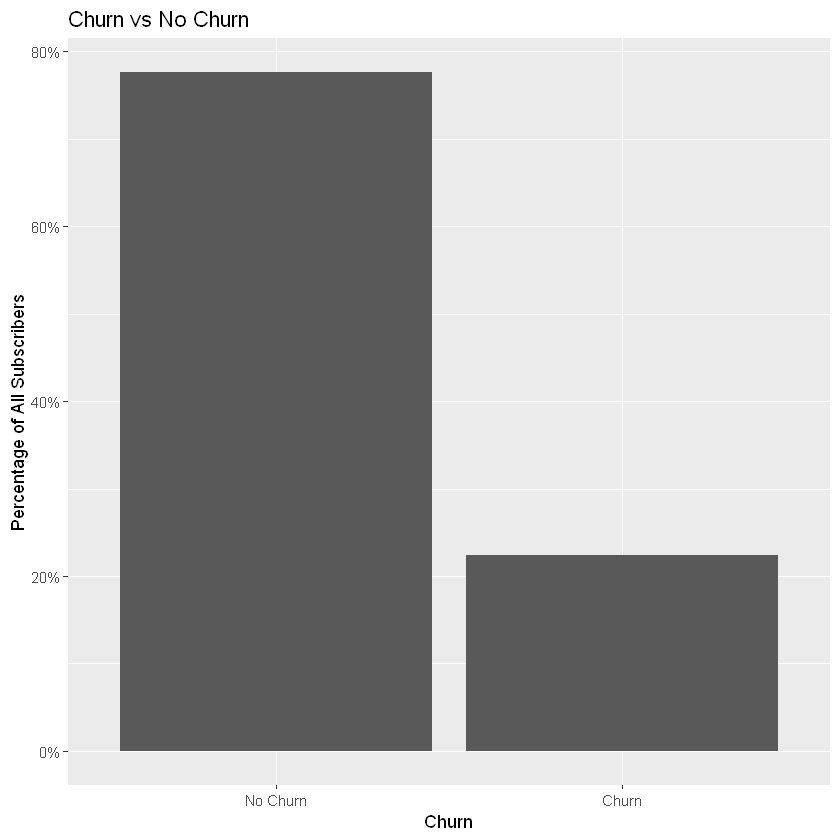

In [505]:
# Basic plot showing churn vs non-churn in our data
g <- ggplot(model_data_discrete,aes(churn_v2))
g + geom_bar(aes(y = (..count..)/sum(..count..)))+
scale_y_continuous(labels = scales::percent)+
# ylab("Percentage of All Subscribers")+
labs(x = 'Churn',y = 'Percentage of All Subscribers',title = 'Churn vs No Churn')



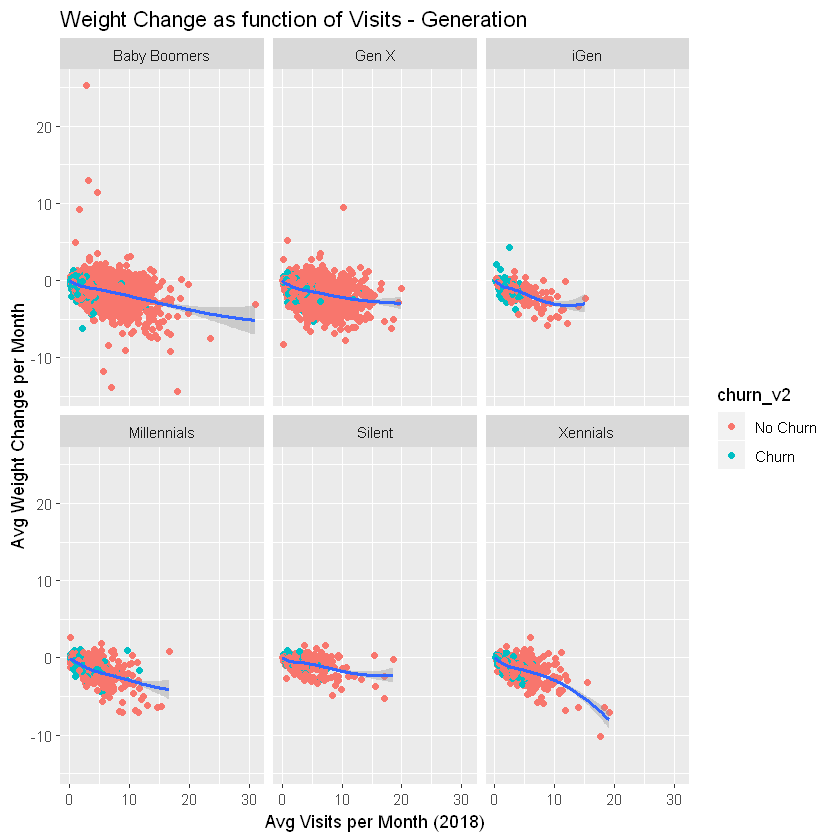

In [428]:
#Let's look at average weight change per month as a function of average visits per month: we expect a high correlation
g2 <- ggplot(model_data_discrete, aes(x = avg_visits, y = avg_weight_change))+
  geom_point(aes(colour = churn_v2))+
  geom_smooth(method = 'loess', formula = y ~ x)+
  facet_wrap(~generation)+
    labs(x = 'Avg Visits per Month (2018)',y = 'Avg Weight Change per Month',title = 'Weight Change as function of Visits - Generation')
  

g2
# ggsave('WtChange_Visits_Generation.png', plot = g2)

### Box Plots of various factors with Churn as the fill

Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."

Saving 6.67 x 6.67 in image
Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."

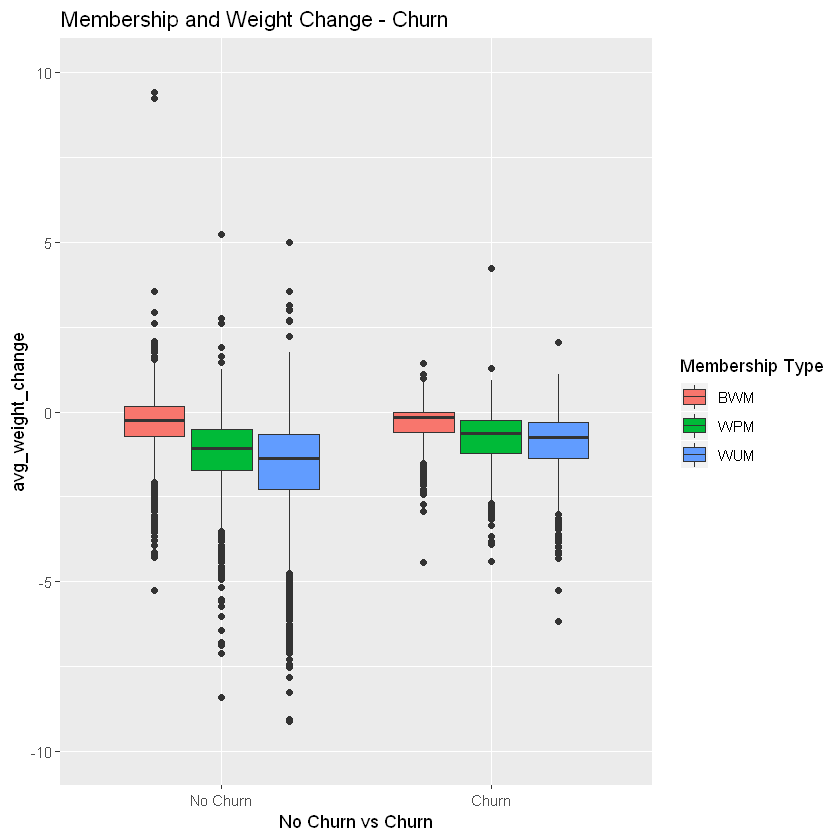

In [572]:
#Now lets look at membership type avg weight change and churn
boxplot_1 <- qplot(x = as.factor(model_data_discrete$churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                 fill = membership, main = "Membership and Weight Change - Churn",xlab = 'No Churn vs Churn', ylim = c(-10,10)) +
 scale_fill_discrete(name="Membership Type")
boxplot_1

ggsave('Membership and weight change.png',boxplot_1)

In [506]:
# #Now lets look at first month sub lost weight vs avg weight change and churn

# boxplot_2 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
#                    fill = `first_month_weightlost binned`, main = "First Month Lost Weight vs Avg Total Weight Change - Churn",
#                   xlab = 'No Churn vs Churn', ylim = c(-10,10))

# boxplot_2


In [507]:
# #Now lets look at first month sub gained weight vs avg weight change and churn

# boxplot_3 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
#                    fill = `first_month_weightgain binned`, main = "First Month Gained Weight and Avg Total Weight Change - Churn",
#                   xlab = 'No Churn vs Churn', ylim = c(-10,10))

# boxplot_3

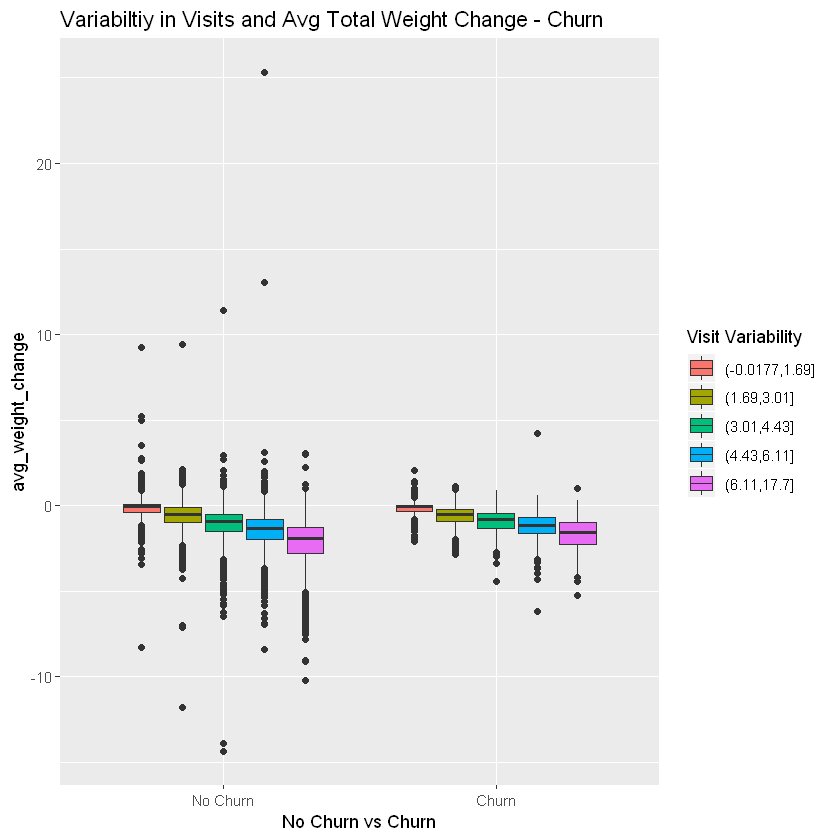

In [570]:
#Now lets look at variability in visits per month vs avg weight change and churn


boxplot_4 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                   fill = `stdev_visits binned`, main = "Variabiltiy in Visits and Avg Total Weight Change - Churn",xlab = 'No Churn vs Churn')+ scale_fill_discrete(name="Visit Variability")
boxplot_4

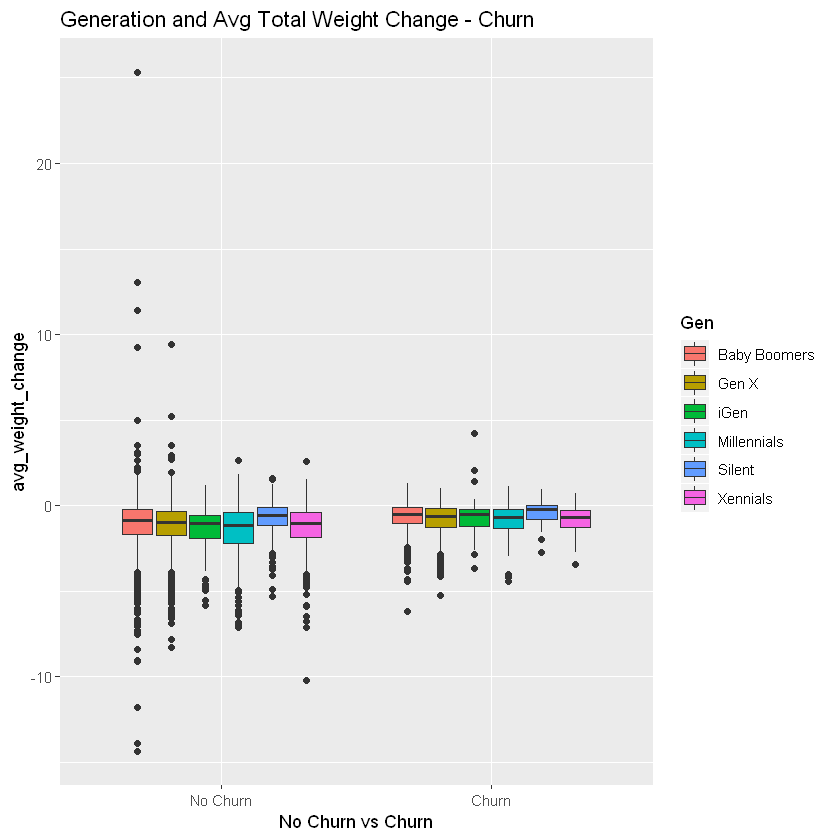

In [571]:
#Now lets look at generation vs avg weight change and churn

boxplot_5 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                   fill = generation, main = "Generation and Avg Total Weight Change - Churn", xlab = 'No Churn vs Churn')+ 
scale_fill_discrete(name="Gen")
boxplot_5

In [187]:
#Need to re-level churn variable since it was throwing off the visualizations
model_data_discrete$churn_v2 <- factor(model_data_discrete$churn_v2,levels(model_data_discrete$churn_v2)[c(2,1)])

### Bar Charts of various factors with Churn as the fill

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

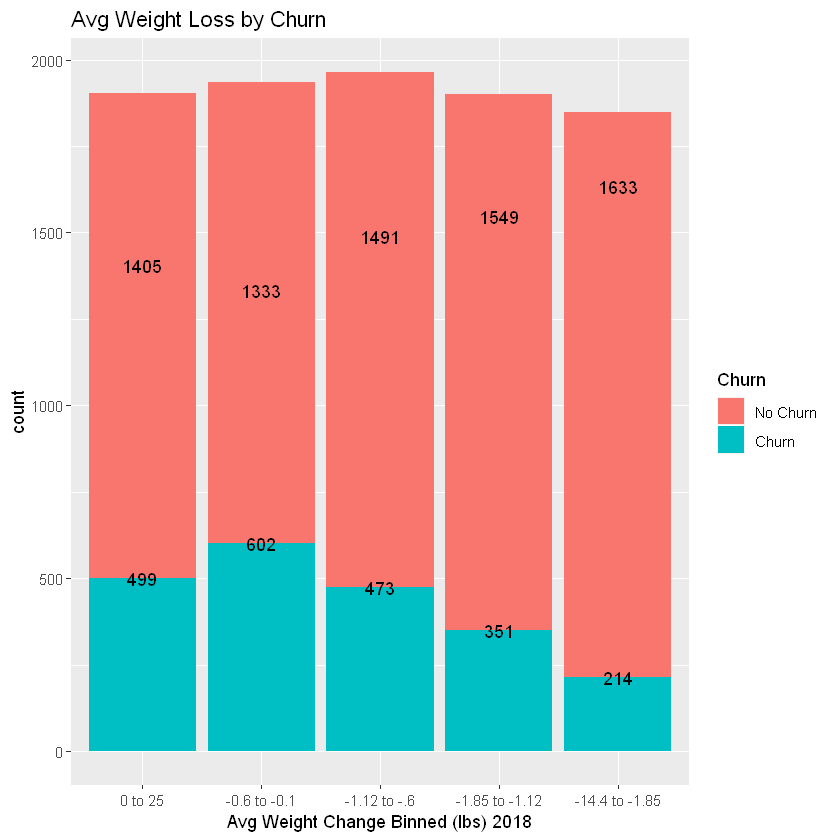

In [604]:
bar_avg_weight_change <- ggplot(data=model_data_discrete, aes(x=`avg_weight_change binned`, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Avg Weight Change Binned (lbs) 2018',title = 'Avg Weight Loss by Churn')+ scale_fill_discrete(name="Churn")
                         
bar_avg_weight_change

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

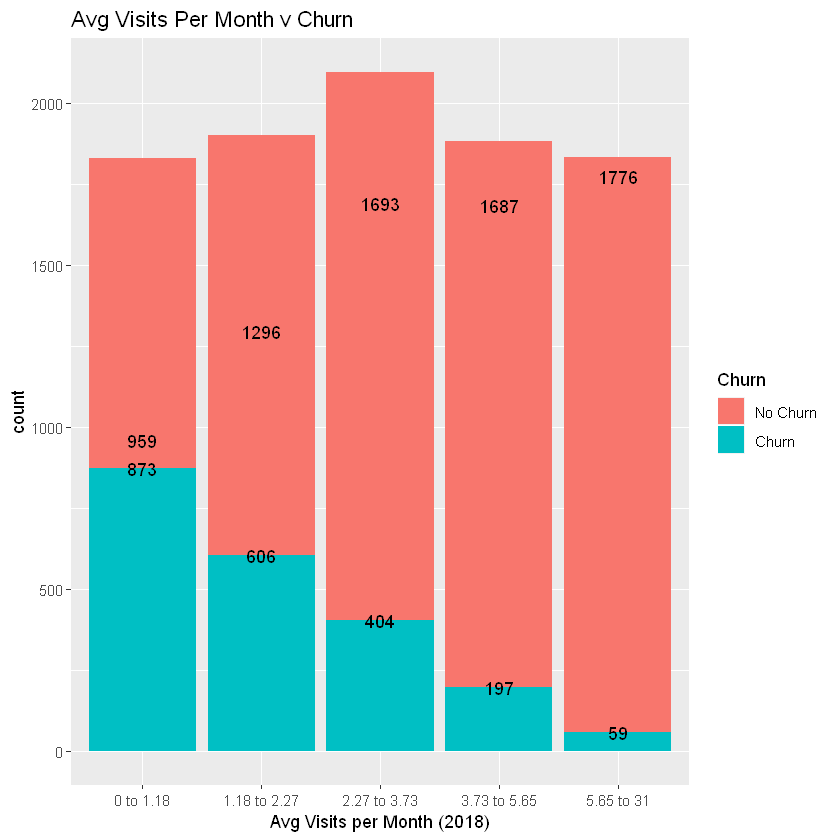

In [512]:
bar_avg_visits <- ggplot(data=model_data_discrete, aes(x=`avg_visits binned`, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Avg Visits per Month (2018)',title = 'Avg Visits Per Month by Churn')+scale_fill_discrete(name="Churn")

bar_avg_visits

# bar_avg_visits

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

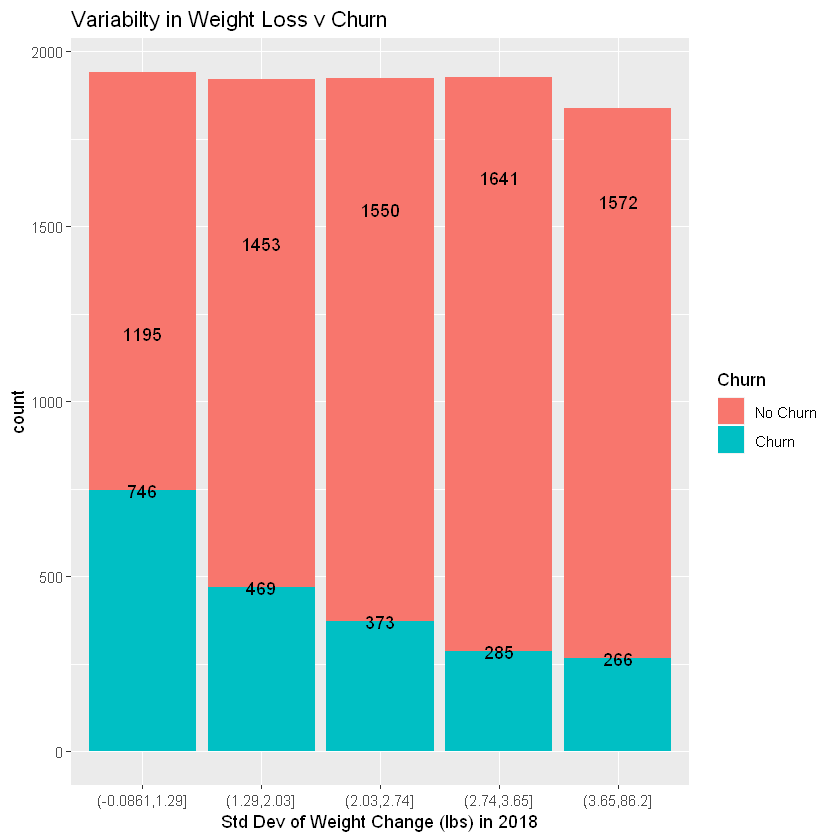

In [573]:
bar_std_weight_change <- ggplot(data=model_data_discrete, aes(x=`stdev_weight_change binned`, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Std Dev of Weight Change (lbs) in 2018',title = 'Variabilty in Weight Loss v Churn')+ 
scale_fill_discrete(name="Churn")

bar_std_weight_change

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

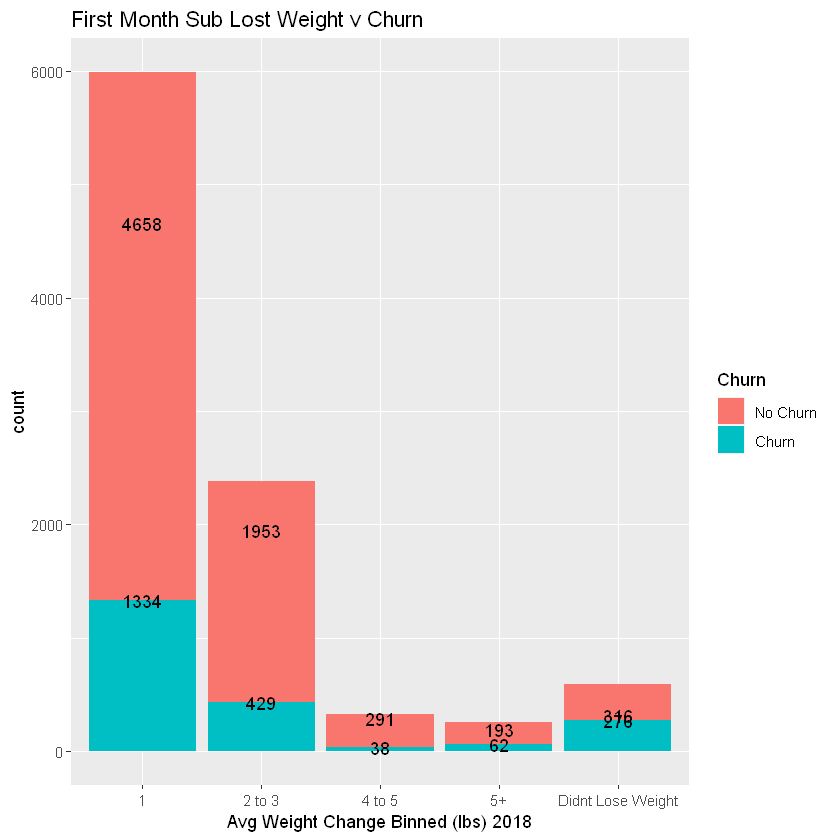

In [606]:
#First month weight lost and gained binned looks off; lets visualize the raw against Churn
#Let's look at average weight change per month as a function of average visits per month: we expect a high correlation
g_fm <- ggplot(data=model_data_discrete, aes(x=model_data_discrete$visitsuntil_weightlost_factor, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Avg Weight Change Binned (lbs) 2018',title = 'First Month Sub Lost Weight v Churn')+ scale_fill_discrete(name="Churn")
                         

  

g_fm
# ggsave('WtChange_Visits_Generation.png', plot = g2)

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

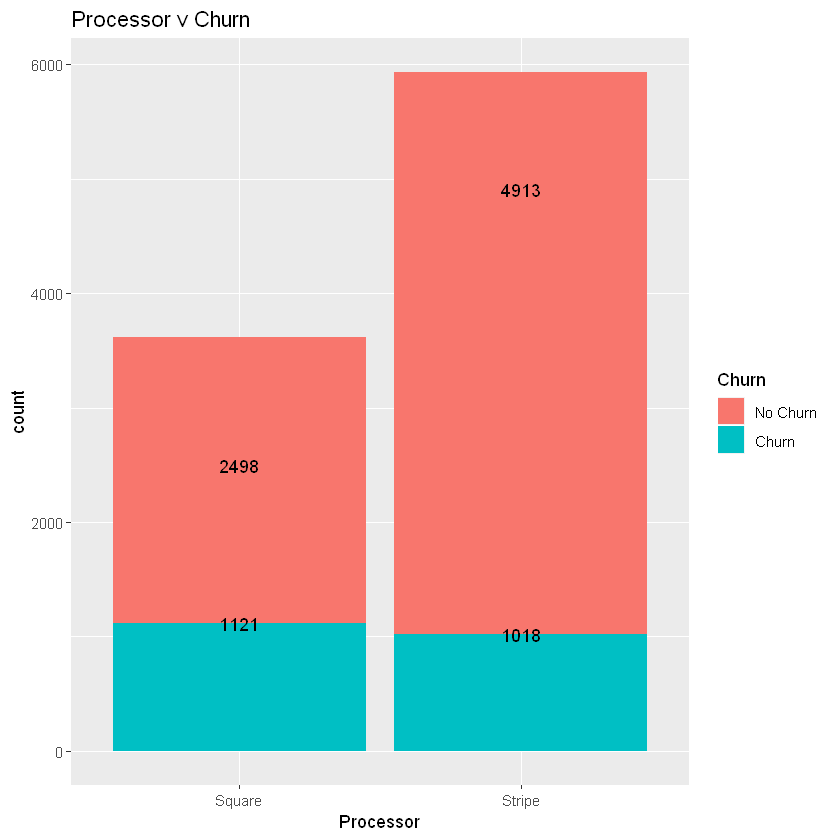

In [575]:
bar_processor <- ggplot(data=model_data_discrete, aes(x=model_data_discrete$processor, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(title = 'Processor v Churn', x = "Processor")+ 
scale_fill_discrete(name="Churn")

bar_processor

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

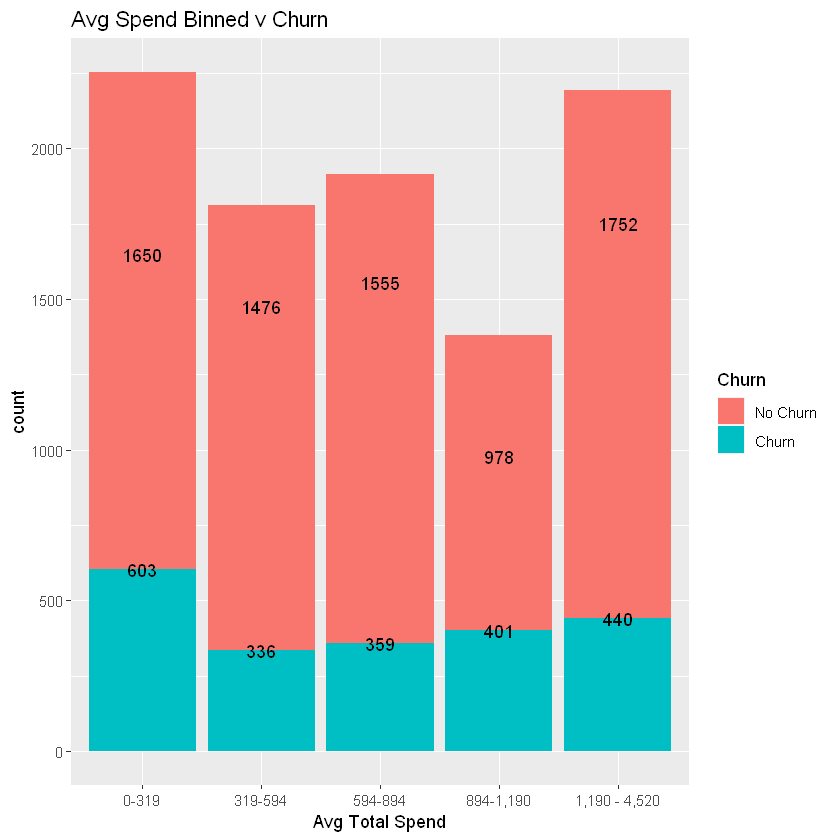

In [586]:
bar_spend_binned <- ggplot(data=model_data_discrete, aes(x=model_data_discrete$`total.spend binned`, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(title = 'Avg Spend Binned v Churn', x = "Avg Total Spend")+
scale_fill_discrete(name="Churn")

bar_spend_binned

In [585]:
# Need to reorder the levels here so that the graph displays correctly. This is an ordered factor so that order matters.
model_data_discrete$`total.spend binned` <- factor(model_data_discrete$`total.spend binned`, levels = c("0-319","319-594","594-894","894-1,190","1,190 - 4,520"))


Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

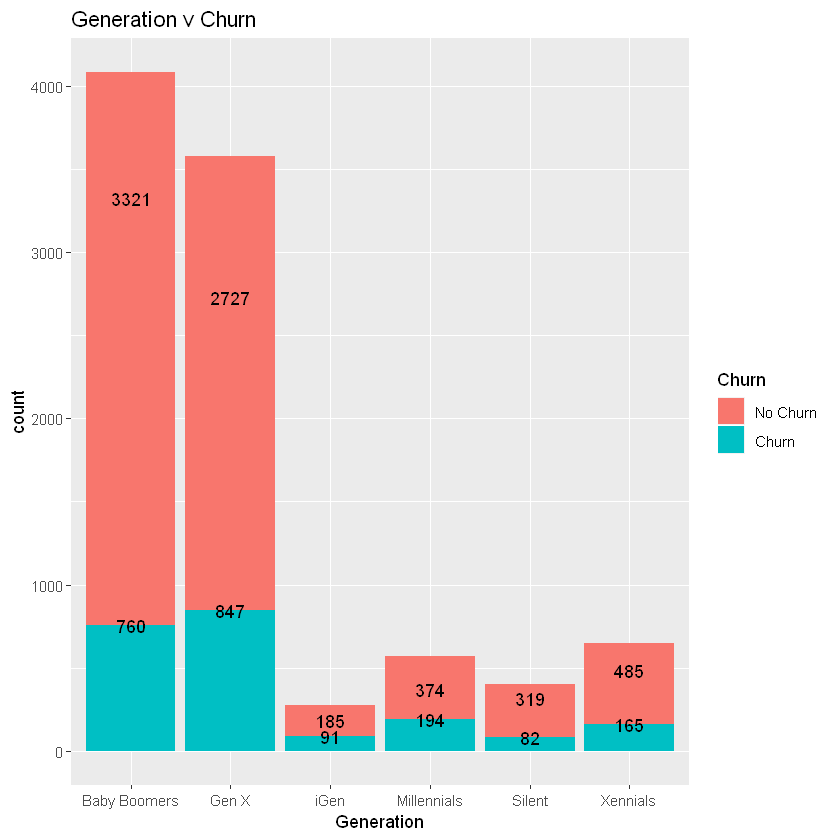

In [589]:

bar_gen <- ggplot(data=model_data_discrete, aes(x=generation, fill = churn_v2)) +
  geom_bar() +
  geom_text(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Generation',title = 'Generation v Churn')+
scale_fill_discrete(name="Churn")

bar_gen

Lets explore plotly in R (the plots crashed my browser so commenting them out for now)

In [379]:
# p <- plot_ly(
#   model_data_discrete, x = ~avg_visits, y = ~avg_weight_change,
#   color = ~predicted_glm_Churn, size = ~predicted_glm_Churn
# )
# p

In [379]:
# p <- plot_ly(
#   model_data_discrete, x = ~avg_visits, y = ~avg_weight_change,
#   color = ~predicted_glm_Churn, size = ~predicted_glm_Churn
# )
# p

In [380]:

# p_3d <- plot_ly(model_data_discrete, x = ~avg_visits, y = ~avg_weight_change, z = ~predicted_glm_Churn, color = ~churn_v2, colors = c('#BF382A', '#0C4B8E')) %>%
#   add_markers() %>%
#   layout(scene = list(xaxis = list(title = 'Avg Monthly Visits'),
#                      yaxis = list(title = 'Avg Monhtly Weight Change'),
#                      zaxis = list(title = 'Predicted Churn Probability')))
# p_3d


## Prep data for modeling: check collinearities, set seed, split and train/fit

Warning message in eval(expr, envir, enclos):
"restarting interrupted promise evaluation"Warning message in eval(expr, envir, enclos):
"internal error -3 in R_decompress1"

ERROR: Error in eval(expr, envir, enclos): lazy-load database 'C:/Users/markl/Anaconda3/Lib/R/library/RColorBrewer/R/RColorBrewer.rdb' is corrupt


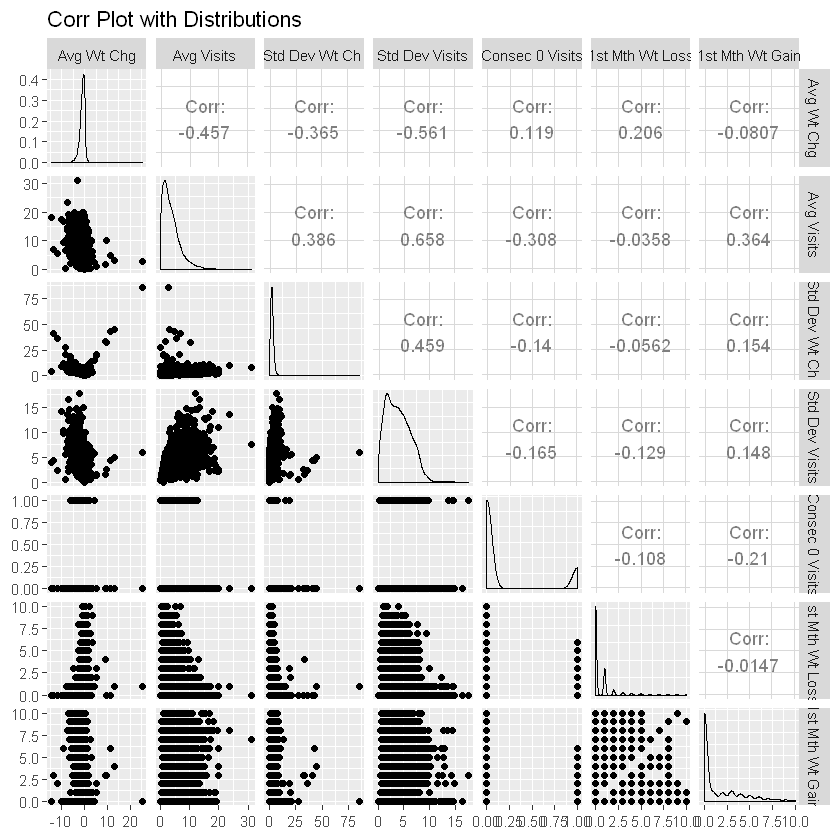

In [520]:
ggpairs(model_data_discrete[,2:8], columnLabels = c("Avg Wt Chg","Avg Visits","Std Dev Wt Ch ","Std Dev Visits","Consec 0 Visits",
                                                   "1st Mth Wt Loss","1st Mth Wt Gain"), title = 'Corr Plot with Distributions')


my_colors <- brewer.pal(nlevels(as.factor(model_data_discrete$churn_v2)), "Set2")

In [ ]:
# Split the data into training and test sets; setting our seed to 123 for reproducible results

In [773]:
set.seed(123)
train_index <- caret::createDataPartition(model_data_discrete$churn_v2,p = 0.7, list = FALSE)
train_set <- model_data_discrete[train_index,]
test_set <- model_data_discrete[-train_index,]

In [ ]:
#Using Caret train function, we can pre-process using centering and scaling

In [774]:
colnames(train_set)

[1] "pid"                           "avg_weight_change"            
 [3] "avg_visits"                    "stdev_weight_change"          
 [5] "stdev_visits"                  "consec_0_visits_v2"           
 [7] "first_month_weightlost"        "first_month_weightgain"       
 [9] "membership"                    "processor"                    
[11] "total.spend"                   "birth.year"                   
[13] "churn_v2"                      "birthyear_factor"             
[15] "generation"                    "avg_weight_change binned"     
[17] "avg_visits binned"             "stdev_weight_change binned"   
[19] "stdev_visits binned"           "first_month_weightlost binned"
[21] "first_month_weightgain binned" "total.spend binned"           
[23] "predicted_glm_NoChurn"         "predicted_glm_Churn"          
[25] "pid2"                          "gender"                       
[27] "visitsuntil_weightlost_factor"

## Fit a Logistic Regression Model with Caret

In [624]:
model_glm <- caret::train(churn_v2 ~ `avg_weight_change binned`+ `avg_visits binned` + gender + visitsuntil_weightlost_factor +
                              `first_month_weightgain binned` + `total.spend binned`+ membership +  generation
                          ,preProc = c("center","scale"),
             data = train_set, method = "glm", family = "binomial")
 
 

In [625]:
model_glm

Generalized Linear Model 

6686 samples
   8 predictor
   2 classes: 'No Churn', 'Churn' 

Pre-processing: centered (26), scaled (26) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 6686, 6686, 6686, 6686, 6686, 6686, ... 
Resampling results:

  Accuracy   Kappa    
  0.7927289  0.2701546


In [626]:
#Calling summary on our model to view the coefficients: the coefficients are in relation to the reference level:
#e.g. avg weight change binned reference level is 
summary(model_glm)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9588  -0.7109  -0.3985  -0.1643   3.0003  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                      -1.67441    0.04423 -37.858
`\\`avg_weight_change binned\\`-0.6 to -0.1`      0.08635    0.04819   1.792
`\\`avg_weight_change binned\\`-1.12 to -.6`      0.06738    0.05194   1.297
`\\`avg_weight_change binned\\`-1.85 to -1.12`    0.01602    0.05565   0.288
`\\`avg_weight_change binned\\`-14.4 to -1.85`   -0.02644    0.06356  -0.416
`\\`avg_visits binned\\`1.18 to 2.27`            -0.27676    0.03863  -7.164
`\\`avg_visits binned\\`2.27 to 3.73`            -0.54787    0.04612 -11.879
`\\`avg_visits binned\\`3.73 to 5.65`            -0.83180    0.05417 -15.355
`\\`avg_visits binned\\`5.65 to 31`              -1.36805    0.07972 -17.161
genderMale                                        0.01748    0.03289   0.532
`visitsuntil

## Explaining the coefficients:
We exponentiate the coefficients to provide us with an interpretable output. 

Each of the coefficient values can be interpreted as follows: 
For each 1 unit change in the variable, the odds of Churn increase (decrease) by the coefficient amount. But, since we binned all of our variables, they are actually in reference to the baseline category. Notice how for generation, Babyboomers isnt listed? well, thats because they are the reference category. So, Gen X has an increased odds ratio of 1.10x, all else equal, of being churn in this model. 


In [839]:
levels(model_data_discrete$generation)

[1] "Baby Boomers" "Gen X"        "iGen"         "Millennials"  "Silent"      
[6] "Xennials"

In [627]:
 exp(coef(model_glm$finalModel))


(Intercept) 
                                       0.1874195 
    `\\`avg_weight_change binned\\`-0.6 to -0.1` 
                                       1.0901899 
    `\\`avg_weight_change binned\\`-1.12 to -.6` 
                                       1.0697013 
  `\\`avg_weight_change binned\\`-1.85 to -1.12` 
                                       1.0161496 
  `\\`avg_weight_change binned\\`-14.4 to -1.85` 
                                       0.9739040 
           `\\`avg_visits binned\\`1.18 to 2.27` 
                                       0.7582337 
           `\\`avg_visits binned\\`2.27 to 3.73` 
                                       0.5781787 
           `\\`avg_visits binned\\`3.73 to 5.65` 
                                       0.4352667 
             `\\`avg_visits binned\\`5.65 to 31` 
                                       0.2546038 
                                      genderMale 
                                       1.0176368 
           `visitsuntil_weightlost_factor2 to 3` 
                                       0.8535209 
           `visitsuntil_weightlost_factor4 to 5` 
                                       0.8934474 
               `visitsuntil_weightlost_factor5+` 
                                       0.9843134 
`visitsuntil_weightlost_factorDidnt Lose Weight` 
                                       0.9977321 
     `\\`first_month_weightgain binned\\`1 to 3` 
                                       0.8753597 
    `\\`first_month_weightgain binned\\`4 to 10` 
                                       0.7302046 
               `\\`total.spend binned\\`319-594` 
                                       0.8040481 
               `\\`total.spend binned\\`594-894` 
                                       0.9656796 
             `\\`total.spend binned\\`894-1,190` 
                                       1.3758188 
         `\\`total.spend binned\\`1,190 - 4,520` 
                                       1.3813497 
                                   membershipWPM 
                                       1.0293239 
                                   membershipWUM 
                                       0.8548281 
                               `generationGen X` 
                                       1.1015893 
                                  generationiGen 
                                       1.0909932 
                           generationMillennials 
                                       1.1918856 
                                generationSilent 
                                       0.9883649 
                              generationXennials 
                                       1.0228953

In [465]:
predictions_glm_1 <- predict(model_glm,test_set, type = "prob")
# colnames(predictions_glm_1) <- c('NoChurn','Churn')

In [854]:
predictions_glm_raw <- predict(model_glm,test_set)

In [853]:
str(test_set$churn_v2)

 Factor w/ 2 levels "No Churn","Churn": 2 1 1 1 2 1 1 1 2 1 ...


In [855]:

confusionMatrix(predictions_glm_raw, test_set_rf$churn_v2, positive = "Churn")

Confusion Matrix and Statistics

          Reference
Prediction No Churn Churn
  No Churn     2112   479
  Churn         111   162
                                          
               Accuracy : 0.794           
                 95% CI : (0.7787, 0.8087)
    No Information Rate : 0.7762          
    P-Value [Acc > NIR] : 0.01125         
                                          
                  Kappa : 0.2549          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.25273         
            Specificity : 0.95007         
         Pos Pred Value : 0.59341         
         Neg Pred Value : 0.81513         
             Prevalence : 0.22381         
         Detection Rate : 0.05656         
   Detection Prevalence : 0.09532         
      Balanced Accuracy : 0.60140         
                                          
       'Positive' Class : Churn           
                                          

## Fit a KNN model with caret

In [729]:
model_knn <- train(churn_v2 ~ `avg_weight_change binned`+ `avg_visits binned` + gender + visitsuntil_weightlost_factor + membership + generation
                   , data = train_set, method = "knn",
                   preProc = c("center","scale"),
                   tuneGrid = data.frame(.k = 1:20),
                   trControl = trainControl(method = "cv"))
predictions_knn <- predict(model_knn,test_set, type = "prob")

In [ ]:
# Need this to draw the ROC curve later
result.roc.knn <- roc(test_set$churn_v2, predictions_knn$Churn) 

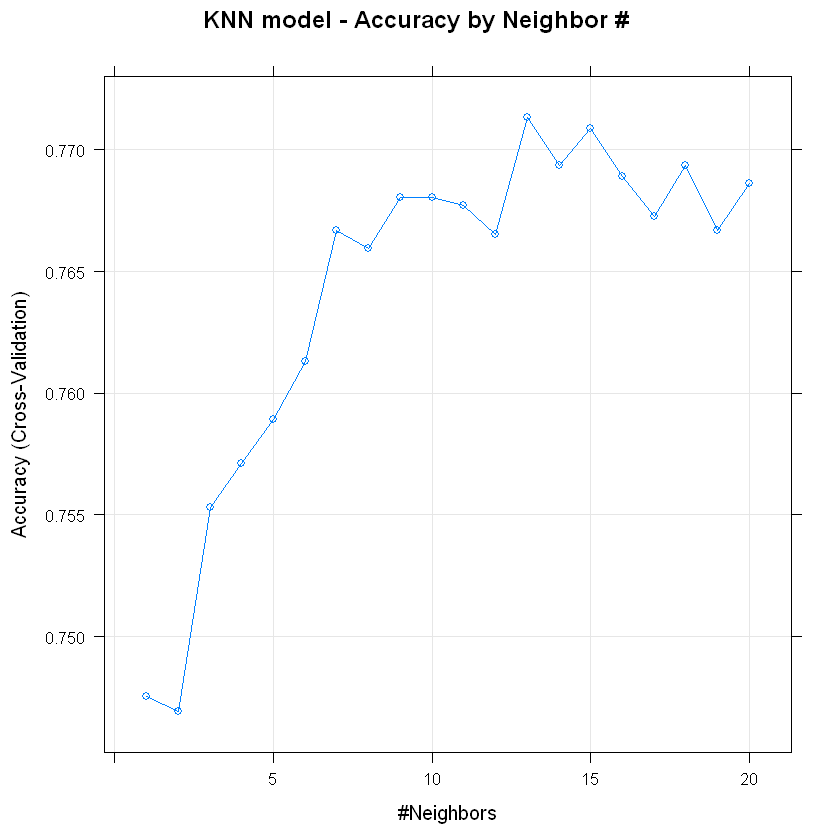

In [718]:
plot(model_knn,main = 'KNN model - Accuracy by Neighbor # ')

## Random Forest
In random forests, the model uses "bootstrapping" which is multiple random sampling; then, using a random subset of predictors
at each stage, fit a tree to each sample which creates the forest. Then, combine all the individual trees to improve predictions.



In [836]:
train_set_rf <- train_set %>% select(churn_v2,`avg_weight_change binned`, `avg_visits binned`, membership, generation, `first_month_weightlost binned`)
test_set_rf <- test_set %>% select(churn_v2,`avg_weight_change binned`, `avg_visits binned`, membership, generation, `first_month_weightlost binned`)
rfmodel <- randomForest(churn_v2 ~ ., data = train_set_rf, ntree = 500, mtry =4, nodesize = 5,
                              importance =TRUE)

In [826]:
rfmodel


Call:
 randomForest(formula = churn_v2 ~ ., data = train_set_rf, ntree = 500,      mtry = 4, nodesize = 5, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 24.23%
Confusion matrix:
         No Churn Churn class.error
No Churn     4758   428  0.08252989
Churn        1191   306  0.79559118

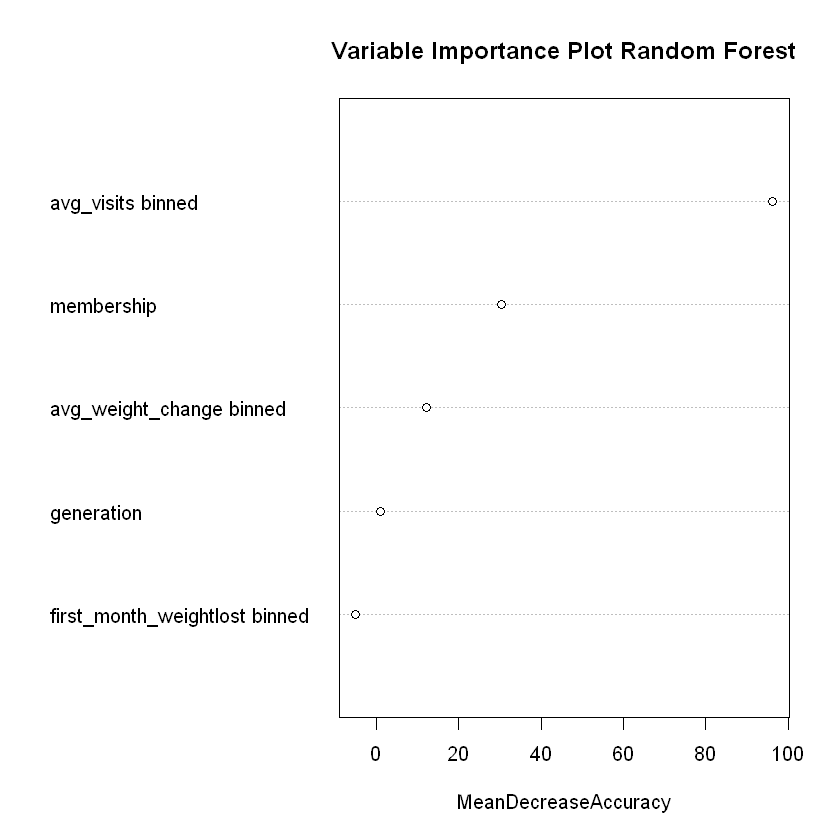

In [819]:
varImpPlot(rfmodel, type = 1, main = "Variable Importance Plot Random Forest")

In [837]:
head(rf_pred[,2])
rf_pred_raw <- predict(rfmodel, test_set_rf_)

2     4    10    16    17    18 
0.790 0.094 0.000 0.000 0.198 0.000

ERROR: Error in as.data.frame(newdata): object 'test_set_rf_' not found


In [838]:
confusionMatrix(rf_pred_raw, test_set_rf$churn_v2, positive = "Churn")

Confusion Matrix and Statistics

          Reference
Prediction No Churn Churn
  No Churn     2053   498
  Churn         170   143
                                          
               Accuracy : 0.7668          
                 95% CI : (0.7508, 0.7821)
    No Information Rate : 0.7762          
    P-Value [Acc > NIR] : 0.8908          
                                          
                  Kappa : 0.1793          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.22309         
            Specificity : 0.92353         
         Pos Pred Value : 0.45687         
         Neg Pred Value : 0.80478         
             Prevalence : 0.22381         
         Detection Rate : 0.04993         
   Detection Prevalence : 0.10929         
      Balanced Accuracy : 0.57331         
                                          
       'Positive' Class : Churn           
                                          

## Evaluating Class Probabilities with ROC Curves and AUC (Area under the Curve)
The Receiver Operating Characteristic (ROC) curve is a tool used to assess how well a model can discriminate between two classes at different thresholds. It graphs the sensitivity % (true positive rate) vs specificity % (1-false positive rate). 
True positive rate is ratio of correctly classifying churners divided by all actual churn; False positive rate is the ratio of falsely predicting churn divided by all those who werent churn.

The AUC, which is the area under the ROC curve, has an important statistical property: the AUC of a classifier is equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.


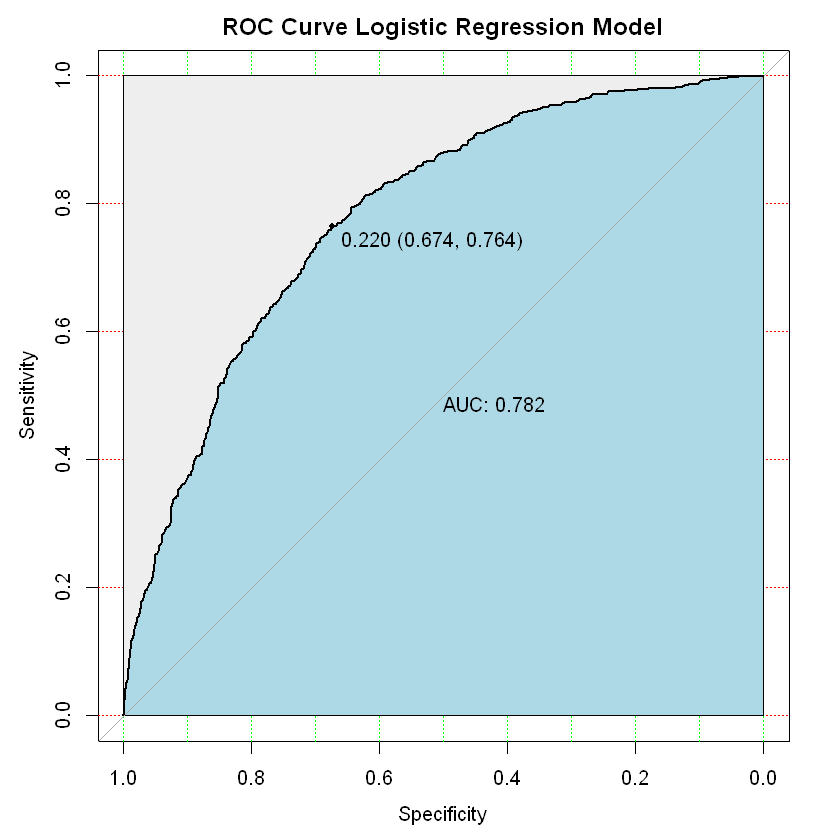

In [719]:
plot.roc(result.roc_glm1, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="light blue", print.thres=TRUE, main = 'ROC Curve Logistic Regression Model')


In [671]:
plot_pred_type_distribution <- function(dfs, threshold) {
  v <- rep(NA, nrow(dfs))
  v <- ifelse(dfs$Churn >= threshold & dfs$churn_v2 == "Churn", "TP", v)
  v <- ifelse(dfs$Churn >= threshold & dfs$churn_v2 == "No Churn", "FP", v)
  v <- ifelse(dfs$Churn < threshold & dfs$churn_v2 == "Churn", "FN", v)
  v <- ifelse(dfs$Churn < threshold & dfs$churn_v2 == "No Churn", "TN", v)
  
  dfs$pred_type <- v
  
  ggplot(data=dfs, aes(x=churn_v2, y=Churn)) + 
    geom_violin(fill=rgb(1,1,1,alpha=0.6), color=NA) + 
    geom_jitter(aes(color=pred_type), alpha=0.6) +
    geom_hline(yintercept=threshold, color="red", alpha=0.6) +
    scale_color_discrete(name = "type") +
    labs(title=sprintf("Visualizing the Model: Threshold at %.2f", threshold))
}

In [ ]:
predictions_full_set <- predict(model_glm,model_data_discrete,type = "prob")

dataforplot_glm1 <- cbind(predictions_full_set,model_data_discrete)


## Visualizing the ROC curve: tradeoff between True & False Negative and True & False Positives

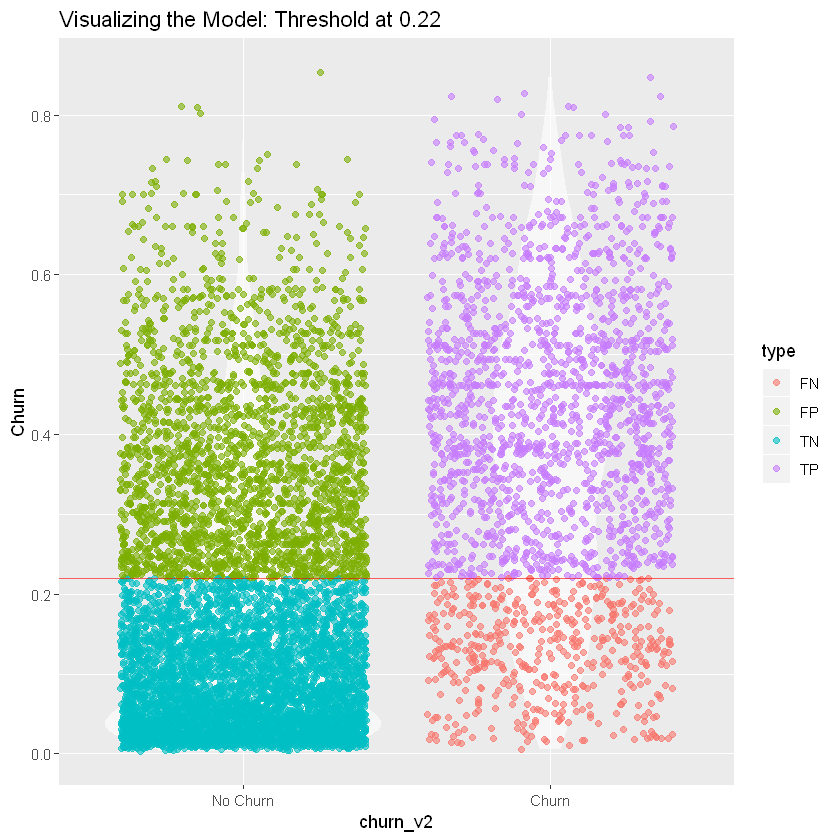

In [702]:
plot_pred_type_distribution(dataforplot_glm1,0.22)

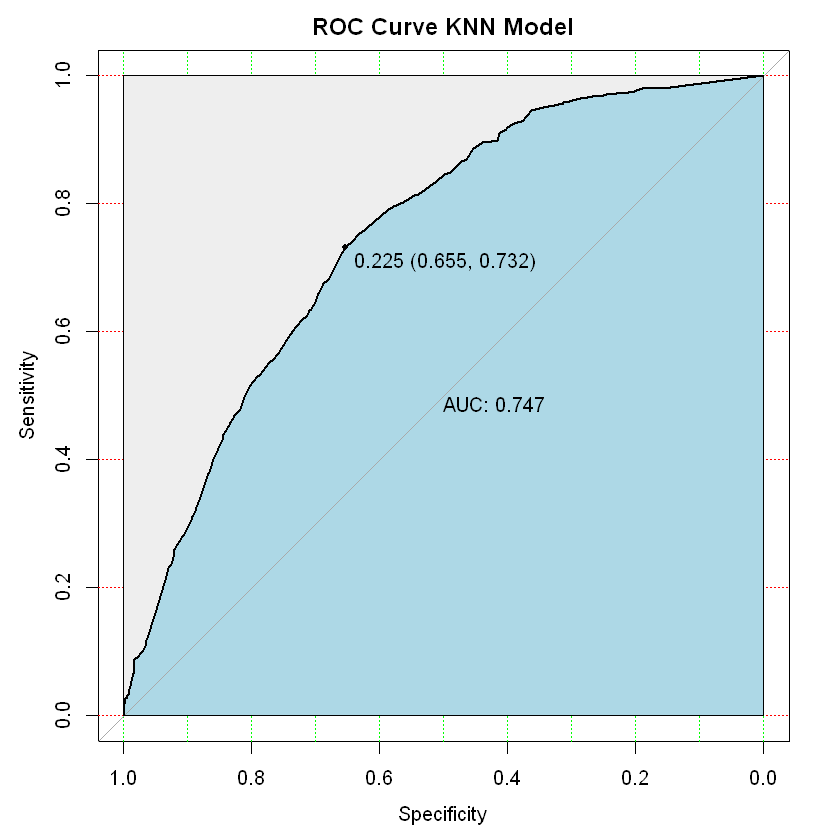

In [551]:
#ROC for KNN
plot.roc(result.roc.knn, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="light blue", print.thres=TRUE, main = 'ROC Curve KNN Model')



In [816]:
#ROC for random forest
rf_pred <- predict(rfmodel, test_set, type = "prob")

In [812]:
result.roc.rf <- roc(test_set$churn_v2, rf_pred[,2])

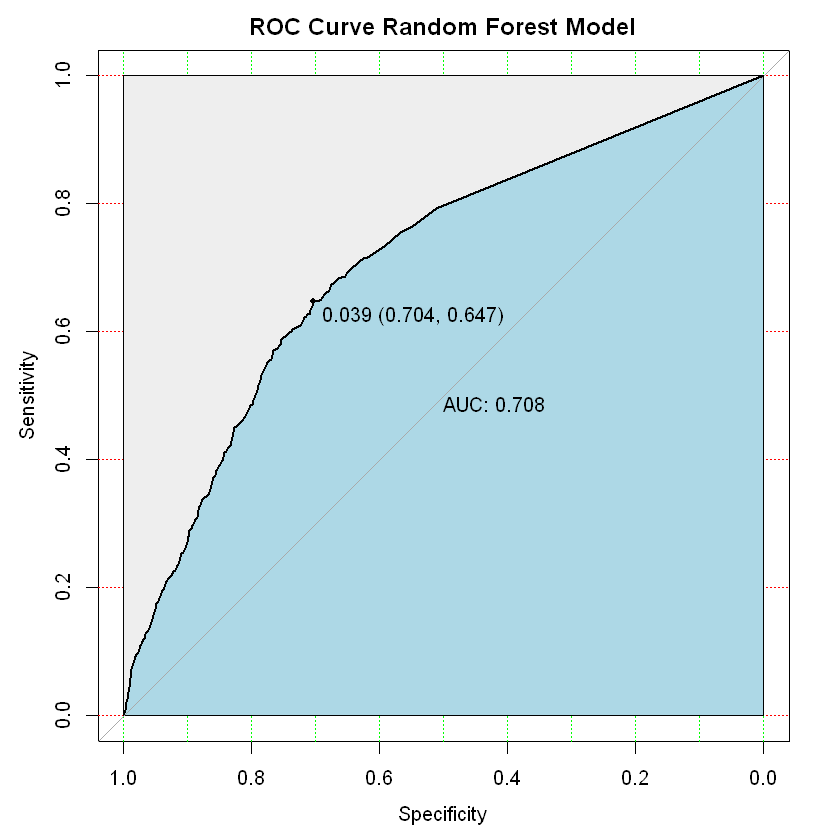

In [813]:
plot.roc(result.roc.rf, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="light blue", print.thres=TRUE, main = 'ROC Curve Random Forest Model')

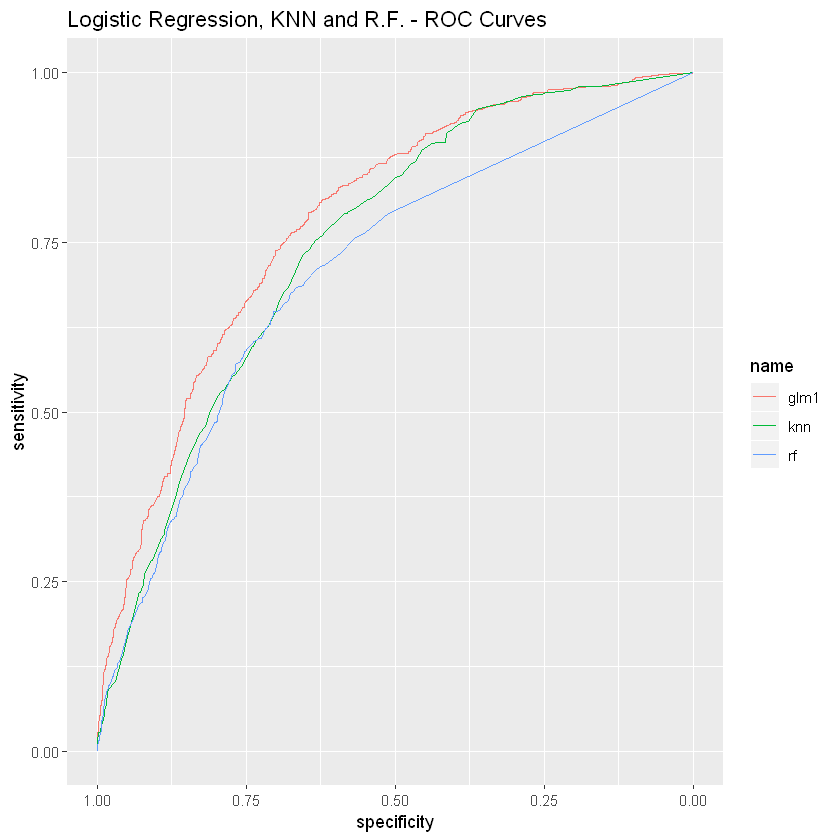

In [815]:
#Lets take a look at all three models together

gg_first_3_mods_ROC <- ggroc(list(glm1 = result.roc_glm1, knn = result.roc.knn,rf = result.roc.rf))
gg_first_3_mods_ROC + ggtitle('Logistic Regression, KNN and R.F. - ROC Curves')

In [840]:
predictions_glm_all_data <- predict(model_glm, model_data_discrete, type = "prob")

In [841]:
dim(predictions_glm_all_data)

[1] 9550    2

In [842]:
head(predictions_glm_all_data)


No Churn,Churn
0.8753424,0.1246576
0.6697341,0.3302659
0.4821546,0.5178454
0.8470631,0.1529369
0.4394196,0.5605804
0.7647015,0.2352985


In [843]:
colnames(predictions_glm_all_data) <- c("GlmPredictedNoChurn","GlmPredictedChurn")


In [844]:
model_data_discrete$predicted_glm_NoChurn <- predictions_glm_all_data$GlmPredictedNoChurn
model_data_discrete$predicted_glm_Churn <- predictions_glm_all_data$GlmPredictedChurn

In [845]:
write.csv(model_data_discrete, 'model_data_final.csv')